# Simple Graph Neural Networks

In this notebook, we will implement an Graph Neural Network (GNN) which predicts LogS and LogP of molecules in ESOL dataset.

## Setting up the notebook and importing the necessary libraries

In [ ]:
!pip install rdkit
!pip install torch_geometric

In [2]:
seed = 42

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from io import StringIO


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import random_split
torch.cuda.manual_seed(seed) # Sets seed for current GPU


from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
from rdkit.Chem.rdchem import BondType
from tqdm import tqdm

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



## Loading the dataset

In [3]:
def load_esol_dataset():
    url = "https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv"
    response = requests.get(url)
    response.raise_for_status()

    df = pd.read_csv(StringIO(response.text))
    print(f"Loaded ESOL with {len(df)} compounds")
    print("Columns in dataset:", df.columns.tolist())
    # Use 'smiles' and 'measured log solubility in mols per litre'
    df = df[['smiles', 'measured log solubility in mols per litre','ESOL predicted log solubility in mols per litre']]
    df.columns = ['SMILES', 'LogS','ESol_Predicted_LogS']

    # Remove invalid SMILES
    valid_smiles = []
    for smiles in df['SMILES']:
        mol = Chem.MolFromSmiles(smiles)
        valid_smiles.append(mol is not None)

    df = df[valid_smiles].reset_index(drop=True)

    return df

# Load dataset
df = load_esol_dataset()

Loaded ESOL with 1128 compounds
Columns in dataset: ['Compound ID', 'ESOL predicted log solubility in mols per litre', 'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area', 'measured log solubility in mols per litre', 'smiles']


### Visualizing the distribution of the labels in the dataset

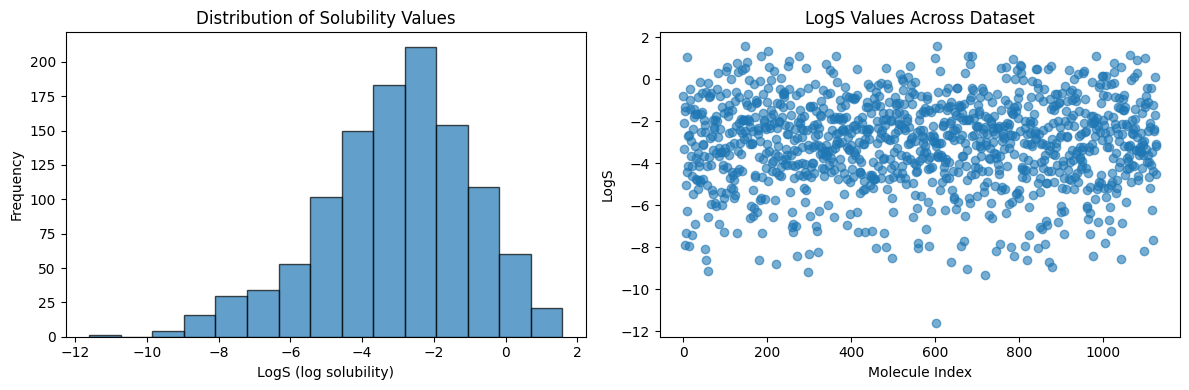

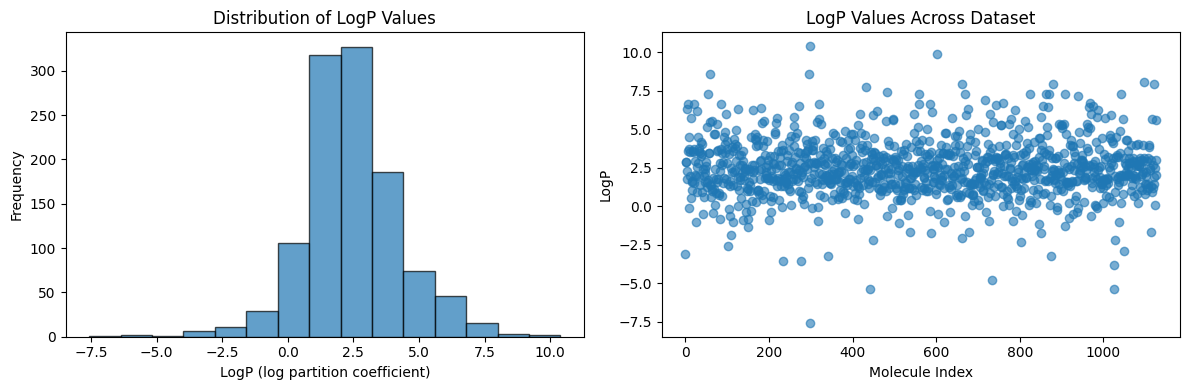

In [4]:
# logS distribution plots

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['LogS'], bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('LogS (log solubility)')
plt.ylabel('Frequency')
plt.title('Distribution of Solubility Values')

plt.subplot(1, 2, 2)
plt.scatter(range(len(df)), df['LogS'], alpha=0.6)
plt.xlabel('Molecule Index')
plt.ylabel('LogS')
plt.title('LogS Values Across Dataset')
plt.tight_layout()
plt.show()

# logP distribution plots

LogP =[]
for smile in df["SMILES"]:
    mol = Chem.MolFromSmiles(smile)
    if mol is not None:
        logp = Crippen.MolLogP(mol)
        LogP.append(logp)
    else:
        LogP.append(np.nan)
df['LogP'] = LogP


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['LogP'], bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('LogP (log partition coefficient)')
plt.ylabel('Frequency')
plt.title('Distribution of LogP Values')
plt.subplot(1, 2, 2)
plt.scatter(range(len(df)), df['LogP'], alpha=0.6)
plt.xlabel('Molecule Index')
plt.ylabel('LogP')
plt.title('LogP Values Across Dataset')
plt.tight_layout()

### Normalizing the target labels (logS and logP)

Here, we normalize the logS and logP labels and then, visualize the normalized values on a plot.

In [5]:
scaler_logS = StandardScaler()
df['logS_scaled'] = scaler_logS.fit_transform(df[['LogS']])
scaler_logP = StandardScaler()
df['logP_scaled'] = scaler_logP.fit_transform(df[['LogP']])

## Data Preprocessing and Preparing the dataset

Helper functions to convert atoms to nodes

In [6]:
COMMON_ATOMS =set() #Atomic numbers of all atoms in dataset
for smile in df["SMILES"]:
    mol = Chem.MolFromSmiles(smile)
    for atom in mol.GetAtoms():
        COMMON_ATOMS.add(atom.GetAtomicNum())
COMMON_ATOMS.add(1) #Hydrogen is not explicitly present in mol.GetAtoms()
COMMON_ATOMS = sorted(list(COMMON_ATOMS))

def one_hot_atomic_number(atomic_num):
    idx = COMMON_ATOMS.index(atomic_num) if atomic_num in COMMON_ATOMS else len(COMMON_ATOMS)
    return F.one_hot(torch.tensor(idx), num_classes=len(COMMON_ATOMS) + 1).float()

def atom_features(atom):
    features = torch.cat([
        one_hot_atomic_number(atom.GetAtomicNum()),  # one-hot atomic number
        torch.tensor([
            atom.GetDegree(),
            atom.GetFormalCharge(),
            atom.GetHybridization().real,
            atom.GetIsAromatic()
        ], dtype=torch.float)
    ])
    return features

Helper functions to convert bonds to edges in the graph

In [7]:
BOND_TYPES = [
    BondType.SINGLE,
    BondType.DOUBLE,
    BondType.TRIPLE,
    BondType.AROMATIC
]

def one_hot_bond_type(bond_type):
    idx = BOND_TYPES.index(bond_type) if bond_type in BOND_TYPES else len(BOND_TYPES)
    return F.one_hot(torch.tensor(idx), num_classes=len(BOND_TYPES) + 1).float()

def bond_features(bond):
    features = torch.cat([
        one_hot_bond_type(bond.GetBondType()),  # one-hot bond type
        torch.tensor([
            bond.GetIsConjugated(),
            bond.IsInRing()
        ], dtype=torch.float)
    ])
    return features

Converting the SMILES strings into graphs.

In [8]:
def smiles_to_data(smiles, y):

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Node features
    x = torch.stack([atom_features(atom) for atom in mol.GetAtoms()])

    # Edge features and connectivity
    edge_index = []
    edge_attr = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        f = bond_features(bond)
        edge_index += [[i, j], [j, i]]
        edge_attr += [f, f]

    if not edge_attr:
      return None

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.stack(edge_attr)

    y = torch.tensor([y], dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

def prepare_dataset(df):
    data_list = []
    for _, row in df.iterrows():
        data = smiles_to_data(row['SMILES'], [row['logS_scaled'], row['logP_scaled']])
        if data:  # Skip invalid SMILES
            data_list.append(data)
    return data_list


Preparing the dataset and making PyTorch dataloaders

In [9]:
data_list = prepare_dataset(df)

loader = DataLoader(data_list, batch_size=32, shuffle=True)
train_set,test_set = random_split(data_list,[0.8 , 0.2])
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)

## Defining the hyperparameters and the model

In [10]:
NUM_EPOCHS = 100
BATCH_SIZE = 8
LEARNING_RATE = 0.001
DROPOUT = 0.2
hidden_channels = 64
PATIENCE = 10  # Early stopping patience
min_delta = 0.001  # Minimum change to qualify as an improvement

In [11]:
class SimpleGNN(nn.Module):
    def __init__(self, num_node_features=15, num_edge_features=7, hidden_channels=64):
        super(SimpleGNN, self).__init__()

        nn1 = nn.Sequential(
            nn.Linear(num_edge_features, 64),
            nn.ReLU(),
            nn.Linear(64, num_node_features * hidden_channels)  # 15 * 64
        )
        self.conv1 = NNConv(num_node_features, hidden_channels, nn1)

        nn2 = nn.Sequential(
            nn.Linear(num_edge_features, 64),
            nn.ReLU(),
            nn.Linear(64, hidden_channels * 32)
        )
        self.conv2 = NNConv(hidden_channels, 32, nn2)

        # Fully connected layers for regression
        self.fc1 = nn.Linear(32, 64)
        self.dropout = nn.Dropout(0.2)
        self.out = nn.Linear(64, 2)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = F.relu(self.conv1(x, edge_index, edge_attr))  # (N_nodes, 64)
        x = F.relu(self.conv2(x, edge_index, edge_attr))  # (N_nodes, 32)
        x = global_add_pool(x, batch)                     # (batch_size, 32)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.out(x)                                # (batch_size, 2) - predicting LogS and LogP

## Training and Evaluating the model

In [12]:
def train_model(model, train_loader, test_loader,criterion,device,num_epochs = NUM_EPOCHS,
                lr=LEARNING_RATE,patience = PATIENCE, min_delta = min_delta):
    optimizer = Adam(model.parameters(), lr=lr)
    model.to(device)
    train_losses=[]
    train_losses_logs = []
    train_losses_logp = []
    test_losses=[]
    test_losses_logs = []
    test_losses_logp = []
    min_test_loss = float('inf')  # Initialize to a large value
    epochs_without_improvement = 0
    best_epoch = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_loss_logs = 0
        train_loss_logp = 0
        for batch in tqdm(train_loader,desc = 'training set'):
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss_logs = criterion(pred[:, 0], batch.y[:, 0])  # LogS loss
            loss_logp = criterion(pred[:, 1], batch.y[:, 1])  # LogP loss
            loss = loss_logs + loss_logp
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_loss_logs += loss_logs.item()
            train_loss_logp += loss_logp.item()
        print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader):.4f} | LogS Loss: {train_loss_logs / len(train_loader):.4f} | LogP Loss: {train_loss_logp / len(train_loader):.4f}")
        train_losses_logs.append(train_loss_logs / len(train_loader))
        train_losses_logp.append(train_loss_logp / len(train_loader))
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        test_loss = 0
        test_loss_logs = 0
        test_loss_logp = 0
        with torch.no_grad():
            for batch in tqdm(test_loader,desc = 'testing set'):
                batch = batch.to(device)
                pred = model(batch)
                loss_logs = criterion(pred[:, 0], batch.y[:, 0]) # LogS loss
                loss_logp = criterion(pred[:, 1], batch.y[:, 1]) # LogP loss
                loss = loss_logs + loss_logp
                test_loss_logs += loss_logs.item()
                test_loss_logp += loss_logp.item()
                test_loss += loss.item()
        print(f"Epoch {epoch+1}, Test Loss: {test_loss / len(test_loader):.4f} | LogS Loss: {test_loss_logs / len(test_loader):.4f} | LogP Loss: {test_loss_logp / len(test_loader):.4f}")
        test_losses.append(test_loss / len(test_loader))
        test_losses_logs.append(test_loss_logs / len(test_loader))
        test_losses_logp.append(test_loss_logp / len(test_loader))
        if((test_loss / len(test_loader)) < min_test_loss - min_delta):
            min_test_loss = (test_loss / len(test_loader))
            epochs_without_improvement =0
            best_epoch = epoch
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement > patience:
                print(f"Early stopping at epoch {epoch+1} with best epoch {best_epoch+1}")
                break

    return train_losses, train_losses_logs, train_losses_logp, test_losses, test_losses_logs, test_losses_logp

Plot training results

In [13]:
def plot_training_results(train_losses, train_losses_logs, train_losses_logp, test_losses, test_losses_logs, test_losses_logp):
    epochs = range(1, len(train_losses) + 1)

    # Plot comparison of all losses
    plt.plot(epochs, train_losses, 'b-', label='Total Train', linewidth=2)
    plt.plot(epochs, test_losses, 'r-', label='Total Test', linewidth=2)
    plt.plot(epochs, train_losses_logs, 'b--', label='Train LogS', alpha=0.7)
    plt.plot(epochs, test_losses_logs, 'r--', label='Test LogS', alpha=0.7)
    plt.plot(epochs, train_losses_logp, 'b:', label='Train LogP', alpha=0.7)
    plt.plot(epochs, test_losses_logp, 'r:', label='Test LogP', alpha=0.7)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Function to evaluate the model

In [14]:
def evaluate_model(model, test_loader, device, scaler_logS=None, scaler_logP=None):

    # Load the best model
    model.to(device)
    model.eval()

    # Collect predictions and actual values
    preds_logs = []
    preds_logp = []
    actual_logs = []
    actual_logp = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Evaluating model'):
            batch = batch.to(device)
            pred = model(batch)

            pred_logs_batch = pred[:, 0].cpu().numpy()
            pred_logp_batch = pred[:, 1].cpu().numpy()
            actual_logs_batch = batch.y[:, 0].cpu().numpy()
            actual_logp_batch = batch.y[:, 1].cpu().numpy()

            preds_logs.extend(pred_logs_batch)
            preds_logp.extend(pred_logp_batch)
            actual_logs.extend(actual_logs_batch)
            actual_logp.extend(actual_logp_batch)

    # Convert to numpy arrays
    preds_logs = np.array(preds_logs)
    preds_logp = np.array(preds_logp)
    actual_logs = np.array(actual_logs)
    actual_logp = np.array(actual_logp)

    # Inverse transform if scalers are provided
    if scaler_logS is not None:
        preds_logs = scaler_logS.inverse_transform(preds_logs.reshape(-1, 1)).flatten()
        actual_logs = scaler_logS.inverse_transform(actual_logs.reshape(-1, 1)).flatten()

    if scaler_logP is not None:
        preds_logp = scaler_logP.inverse_transform(preds_logp.reshape(-1, 1)).flatten()
        actual_logp = scaler_logP.inverse_transform(actual_logp.reshape(-1, 1)).flatten()

    # Calculate metrics for LogS
    mse_logs = mean_squared_error(actual_logs, preds_logs)
    mae_logs = mean_absolute_error(actual_logs, preds_logs)
    r2_logs = r2_score(actual_logs, preds_logs)
    rmse_logs = np.sqrt(mse_logs)

    # Calculate metrics for LogP
    mse_logp = mean_squared_error(actual_logp, preds_logp)
    mae_logp = mean_absolute_error(actual_logp, preds_logp)
    r2_logp = r2_score(actual_logp, preds_logp)
    rmse_logp = np.sqrt(mse_logp)



    print("LogS PREDICTION METRICS:")
    print(f"  MSE:  {mse_logs:.4f}")
    print(f"  RMSE: {rmse_logs:.4f}")
    print(f"  MAE:  {mae_logs:.4f}")
    print(f"  R²:   {r2_logs:.4f}")
    print()

    print("LogP PREDICTION METRICS:")
    print(f"  MSE:  {mse_logp:.4f}")
    print(f"  RMSE: {rmse_logp:.4f}")
    print(f"  MAE:  {mae_logp:.4f}")
    print(f"  R²:   {r2_logp:.4f}")

    # Create comprehensive plots
    fig, axes = plt.subplots(1, 2, figsize=(18, 12))

    # Plot 1: LogS True vs Predicted
    axes[0].scatter(actual_logs, preds_logs, alpha=0.6, color='blue', s=20)
    min_val = min(min(actual_logs), min(preds_logs))
    max_val = max(max(actual_logs), max(preds_logs))
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    axes[0].set_xlabel('True LogS')
    axes[0].set_ylabel('Predicted LogS')
    axes[0].set_title(f'LogS: True vs Predicted (R² = {r2_logs:.3f})')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    axes[1].scatter(actual_logp, preds_logp, alpha=0.6, color='green', s=20)
    min_val = min(min(actual_logp), min(preds_logp))
    max_val = max(max(actual_logp), max(preds_logp))
    axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    axes[1].set_xlabel('True LogP')
    axes[1].set_ylabel('Predicted LogP')
    axes[1].set_title(f'LogP: True vs Predicted (R² = {r2_logp:.3f})')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    return {
        "mae_logs": mae_logs,
        "mae_logp": mae_logp,
        "r2 logs": r2_logs,
        "r2 logp": r2_logp}

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleGNN(num_node_features=data_list[0].x.shape[1], num_edge_features=data_list[0].edge_attr.shape[1], hidden_channels=hidden_channels).to(device)

train_losses, train_losses_logs, train_losses_logp, test_losses, test_losses_logs, test_losses_logp = train_model(
    model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=MSELoss(),
    device=device,
    num_epochs=NUM_EPOCHS,
    lr=LEARNING_RATE,
    patience=PATIENCE,
    min_delta=min_delta
)

training set: 100%|██████████| 902/902 [00:10<00:00, 82.99it/s] 


Epoch 1, Train Loss: 2.3577 | LogS Loss: 1.1596 | LogP Loss: 1.1981


testing set: 100%|██████████| 225/225 [00:00<00:00, 465.60it/s]


Epoch 1, Test Loss: 2.3046 | LogS Loss: 1.0598 | LogP Loss: 1.2448


training set: 100%|██████████| 902/902 [00:04<00:00, 188.30it/s]


Epoch 2, Train Loss: 1.8946 | LogS Loss: 1.0065 | LogP Loss: 0.8881


testing set: 100%|██████████| 225/225 [00:00<00:00, 480.45it/s]


Epoch 2, Test Loss: 2.3063 | LogS Loss: 1.0659 | LogP Loss: 1.2404


training set: 100%|██████████| 902/902 [00:04<00:00, 208.77it/s]


Epoch 3, Train Loss: 1.8299 | LogS Loss: 0.9853 | LogP Loss: 0.8446


testing set: 100%|██████████| 225/225 [00:00<00:00, 477.26it/s]


Epoch 3, Test Loss: 2.2402 | LogS Loss: 1.0567 | LogP Loss: 1.1835


training set: 100%|██████████| 902/902 [00:04<00:00, 197.85it/s]


Epoch 4, Train Loss: 1.7133 | LogS Loss: 0.8957 | LogP Loss: 0.8176


testing set: 100%|██████████| 225/225 [00:00<00:00, 330.64it/s]


Epoch 4, Test Loss: 1.9024 | LogS Loss: 0.8846 | LogP Loss: 1.0178


training set: 100%|██████████| 902/902 [00:04<00:00, 206.46it/s]


Epoch 5, Train Loss: 1.2214 | LogS Loss: 0.6860 | LogP Loss: 0.5354


testing set: 100%|██████████| 225/225 [00:00<00:00, 463.70it/s]


Epoch 5, Test Loss: 1.5909 | LogS Loss: 0.7758 | LogP Loss: 0.8151


training set: 100%|██████████| 902/902 [00:04<00:00, 209.59it/s]


Epoch 6, Train Loss: 1.1601 | LogS Loss: 0.6499 | LogP Loss: 0.5101


testing set: 100%|██████████| 225/225 [00:00<00:00, 479.23it/s]


Epoch 6, Test Loss: 1.5363 | LogS Loss: 0.7157 | LogP Loss: 0.8206


training set: 100%|██████████| 902/902 [00:04<00:00, 189.94it/s]


Epoch 7, Train Loss: 1.1193 | LogS Loss: 0.6160 | LogP Loss: 0.5033


testing set: 100%|██████████| 225/225 [00:00<00:00, 472.26it/s]


Epoch 7, Test Loss: 1.4899 | LogS Loss: 0.6818 | LogP Loss: 0.8081


training set: 100%|██████████| 902/902 [00:04<00:00, 211.47it/s]


Epoch 8, Train Loss: 1.0445 | LogS Loss: 0.5861 | LogP Loss: 0.4583


testing set: 100%|██████████| 225/225 [00:00<00:00, 467.29it/s]


Epoch 8, Test Loss: 1.5315 | LogS Loss: 0.6884 | LogP Loss: 0.8431


training set: 100%|██████████| 902/902 [00:04<00:00, 190.19it/s]


Epoch 9, Train Loss: 1.0587 | LogS Loss: 0.5881 | LogP Loss: 0.4706


testing set: 100%|██████████| 225/225 [00:00<00:00, 466.08it/s]


Epoch 9, Test Loss: 1.4729 | LogS Loss: 0.6710 | LogP Loss: 0.8019


training set: 100%|██████████| 902/902 [00:04<00:00, 211.99it/s]


Epoch 10, Train Loss: 0.9898 | LogS Loss: 0.5501 | LogP Loss: 0.4396


testing set: 100%|██████████| 225/225 [00:00<00:00, 481.77it/s]


Epoch 10, Test Loss: 1.4681 | LogS Loss: 0.6473 | LogP Loss: 0.8208


training set: 100%|██████████| 902/902 [00:04<00:00, 208.35it/s]


Epoch 11, Train Loss: 0.9705 | LogS Loss: 0.5451 | LogP Loss: 0.4254


testing set: 100%|██████████| 225/225 [00:00<00:00, 375.01it/s]


Epoch 11, Test Loss: 1.3785 | LogS Loss: 0.6042 | LogP Loss: 0.7743


training set: 100%|██████████| 902/902 [00:04<00:00, 191.18it/s]


Epoch 12, Train Loss: 0.9194 | LogS Loss: 0.4991 | LogP Loss: 0.4202


testing set: 100%|██████████| 225/225 [00:00<00:00, 483.73it/s]


Epoch 12, Test Loss: 1.4669 | LogS Loss: 0.6647 | LogP Loss: 0.8021


training set: 100%|██████████| 902/902 [00:04<00:00, 211.89it/s]


Epoch 13, Train Loss: 0.8954 | LogS Loss: 0.4886 | LogP Loss: 0.4068


testing set: 100%|██████████| 225/225 [00:00<00:00, 467.57it/s]


Epoch 13, Test Loss: 1.3338 | LogS Loss: 0.6019 | LogP Loss: 0.7319


training set: 100%|██████████| 902/902 [00:04<00:00, 188.19it/s]


Epoch 14, Train Loss: 0.8491 | LogS Loss: 0.4721 | LogP Loss: 0.3770


testing set: 100%|██████████| 225/225 [00:00<00:00, 462.14it/s]


Epoch 14, Test Loss: 1.2759 | LogS Loss: 0.5554 | LogP Loss: 0.7205


training set: 100%|██████████| 902/902 [00:04<00:00, 210.64it/s]


Epoch 15, Train Loss: 1.2030 | LogS Loss: 0.6548 | LogP Loss: 0.5483


testing set: 100%|██████████| 225/225 [00:00<00:00, 484.99it/s]


Epoch 15, Test Loss: 1.5997 | LogS Loss: 0.7158 | LogP Loss: 0.8839


training set: 100%|██████████| 902/902 [00:04<00:00, 202.24it/s]


Epoch 16, Train Loss: 0.9567 | LogS Loss: 0.5303 | LogP Loss: 0.4264


testing set: 100%|██████████| 225/225 [00:00<00:00, 378.45it/s]


Epoch 16, Test Loss: 1.4556 | LogS Loss: 0.6779 | LogP Loss: 0.7777


training set: 100%|██████████| 902/902 [00:04<00:00, 197.36it/s]


Epoch 17, Train Loss: 0.8386 | LogS Loss: 0.4628 | LogP Loss: 0.3758


testing set: 100%|██████████| 225/225 [00:00<00:00, 473.81it/s]


Epoch 17, Test Loss: 1.2500 | LogS Loss: 0.4818 | LogP Loss: 0.7682


training set: 100%|██████████| 902/902 [00:04<00:00, 207.46it/s]


Epoch 18, Train Loss: 0.6639 | LogS Loss: 0.3587 | LogP Loss: 0.3052


testing set: 100%|██████████| 225/225 [00:00<00:00, 469.34it/s]


Epoch 18, Test Loss: 0.9387 | LogS Loss: 0.3751 | LogP Loss: 0.5636


training set: 100%|██████████| 902/902 [00:05<00:00, 175.53it/s]


Epoch 19, Train Loss: 0.5115 | LogS Loss: 0.2840 | LogP Loss: 0.2275


testing set: 100%|██████████| 225/225 [00:00<00:00, 468.33it/s]


Epoch 19, Test Loss: 0.8474 | LogS Loss: 0.3315 | LogP Loss: 0.5159


training set: 100%|██████████| 902/902 [00:04<00:00, 208.76it/s]


Epoch 20, Train Loss: 0.4821 | LogS Loss: 0.2733 | LogP Loss: 0.2088


testing set: 100%|██████████| 225/225 [00:00<00:00, 479.80it/s]


Epoch 20, Test Loss: 0.6717 | LogS Loss: 0.2797 | LogP Loss: 0.3920


training set: 100%|██████████| 902/902 [00:04<00:00, 187.84it/s]


Epoch 21, Train Loss: 0.4457 | LogS Loss: 0.2560 | LogP Loss: 0.1898


testing set: 100%|██████████| 225/225 [00:00<00:00, 482.59it/s]


Epoch 21, Test Loss: 0.6494 | LogS Loss: 0.2885 | LogP Loss: 0.3609


training set: 100%|██████████| 902/902 [00:04<00:00, 209.75it/s]


Epoch 22, Train Loss: 0.4802 | LogS Loss: 0.2779 | LogP Loss: 0.2023


testing set: 100%|██████████| 225/225 [00:00<00:00, 487.55it/s]


Epoch 22, Test Loss: 0.9074 | LogS Loss: 0.3637 | LogP Loss: 0.5438


training set: 100%|██████████| 902/902 [00:04<00:00, 209.50it/s]


Epoch 23, Train Loss: 0.4319 | LogS Loss: 0.2572 | LogP Loss: 0.1747


testing set: 100%|██████████| 225/225 [00:00<00:00, 368.72it/s]


Epoch 23, Test Loss: 0.4563 | LogS Loss: 0.2176 | LogP Loss: 0.2386


training set: 100%|██████████| 902/902 [00:04<00:00, 191.12it/s]


Epoch 24, Train Loss: 0.3590 | LogS Loss: 0.2160 | LogP Loss: 0.1430


testing set: 100%|██████████| 225/225 [00:00<00:00, 469.77it/s]


Epoch 24, Test Loss: 0.5254 | LogS Loss: 0.3630 | LogP Loss: 0.1624


training set: 100%|██████████| 902/902 [00:09<00:00, 97.18it/s]


Epoch 25, Train Loss: 0.2836 | LogS Loss: 0.1813 | LogP Loss: 0.1023


testing set: 100%|██████████| 225/225 [00:00<00:00, 318.53it/s]


Epoch 25, Test Loss: 0.3261 | LogS Loss: 0.2423 | LogP Loss: 0.0838


training set: 100%|██████████| 902/902 [00:04<00:00, 210.57it/s]


Epoch 26, Train Loss: 0.2620 | LogS Loss: 0.1656 | LogP Loss: 0.0964


testing set: 100%|██████████| 225/225 [00:00<00:00, 469.02it/s]


Epoch 26, Test Loss: 0.2296 | LogS Loss: 0.1541 | LogP Loss: 0.0754


training set: 100%|██████████| 902/902 [00:04<00:00, 207.34it/s]


Epoch 27, Train Loss: 0.2387 | LogS Loss: 0.1541 | LogP Loss: 0.0846


testing set: 100%|██████████| 225/225 [00:00<00:00, 341.52it/s]


Epoch 27, Test Loss: 0.2446 | LogS Loss: 0.1581 | LogP Loss: 0.0864


training set: 100%|██████████| 902/902 [00:04<00:00, 194.41it/s]


Epoch 28, Train Loss: 0.2381 | LogS Loss: 0.1567 | LogP Loss: 0.0814


testing set: 100%|██████████| 225/225 [00:00<00:00, 479.44it/s]


Epoch 28, Test Loss: 0.2384 | LogS Loss: 0.1614 | LogP Loss: 0.0770


training set: 100%|██████████| 902/902 [00:04<00:00, 210.70it/s]


Epoch 29, Train Loss: 0.2163 | LogS Loss: 0.1484 | LogP Loss: 0.0679


testing set: 100%|██████████| 225/225 [00:00<00:00, 489.67it/s]


Epoch 29, Test Loss: 0.2760 | LogS Loss: 0.1500 | LogP Loss: 0.1261


training set: 100%|██████████| 902/902 [00:04<00:00, 191.00it/s]


Epoch 30, Train Loss: 0.2261 | LogS Loss: 0.1493 | LogP Loss: 0.0768


testing set: 100%|██████████| 225/225 [00:00<00:00, 466.36it/s]


Epoch 30, Test Loss: 0.2470 | LogS Loss: 0.1807 | LogP Loss: 0.0663


training set: 100%|██████████| 902/902 [00:04<00:00, 210.32it/s]


Epoch 31, Train Loss: 0.2306 | LogS Loss: 0.1513 | LogP Loss: 0.0793


testing set: 100%|██████████| 225/225 [00:00<00:00, 469.47it/s]


Epoch 31, Test Loss: 0.2156 | LogS Loss: 0.1576 | LogP Loss: 0.0580


training set: 100%|██████████| 902/902 [00:04<00:00, 206.08it/s]


Epoch 32, Train Loss: 0.1955 | LogS Loss: 0.1232 | LogP Loss: 0.0723


testing set: 100%|██████████| 225/225 [00:00<00:00, 374.96it/s]


Epoch 32, Test Loss: 0.2066 | LogS Loss: 0.1556 | LogP Loss: 0.0511


training set: 100%|██████████| 902/902 [00:04<00:00, 203.94it/s]


Epoch 33, Train Loss: 0.1962 | LogS Loss: 0.1292 | LogP Loss: 0.0670


testing set: 100%|██████████| 225/225 [00:00<00:00, 476.99it/s]


Epoch 33, Test Loss: 0.2024 | LogS Loss: 0.1484 | LogP Loss: 0.0540


training set: 100%|██████████| 902/902 [00:04<00:00, 210.76it/s]


Epoch 34, Train Loss: 0.2100 | LogS Loss: 0.1401 | LogP Loss: 0.0699


testing set: 100%|██████████| 225/225 [00:00<00:00, 473.20it/s]


Epoch 34, Test Loss: 0.2392 | LogS Loss: 0.1557 | LogP Loss: 0.0836


training set: 100%|██████████| 902/902 [00:04<00:00, 189.69it/s]


Epoch 35, Train Loss: 0.1854 | LogS Loss: 0.1239 | LogP Loss: 0.0615


testing set: 100%|██████████| 225/225 [00:00<00:00, 468.18it/s]


Epoch 35, Test Loss: 0.1963 | LogS Loss: 0.1393 | LogP Loss: 0.0569


training set: 100%|██████████| 902/902 [00:04<00:00, 213.49it/s]


Epoch 36, Train Loss: 0.1823 | LogS Loss: 0.1177 | LogP Loss: 0.0646


testing set: 100%|██████████| 225/225 [00:00<00:00, 479.88it/s]


Epoch 36, Test Loss: 0.1705 | LogS Loss: 0.1310 | LogP Loss: 0.0395


training set: 100%|██████████| 902/902 [00:04<00:00, 194.32it/s]


Epoch 37, Train Loss: 0.1758 | LogS Loss: 0.1202 | LogP Loss: 0.0556


testing set: 100%|██████████| 225/225 [00:00<00:00, 381.20it/s]


Epoch 37, Test Loss: 0.1725 | LogS Loss: 0.1361 | LogP Loss: 0.0364


training set: 100%|██████████| 902/902 [00:04<00:00, 211.66it/s]


Epoch 38, Train Loss: 0.1798 | LogS Loss: 0.1191 | LogP Loss: 0.0606


testing set: 100%|██████████| 225/225 [00:00<00:00, 471.69it/s]


Epoch 38, Test Loss: 0.2834 | LogS Loss: 0.1364 | LogP Loss: 0.1469


training set: 100%|██████████| 902/902 [00:04<00:00, 210.15it/s]


Epoch 39, Train Loss: 0.1768 | LogS Loss: 0.1174 | LogP Loss: 0.0595


testing set: 100%|██████████| 225/225 [00:00<00:00, 461.26it/s]


Epoch 39, Test Loss: 0.2144 | LogS Loss: 0.1476 | LogP Loss: 0.0667


training set: 100%|██████████| 902/902 [00:04<00:00, 191.21it/s]


Epoch 40, Train Loss: 0.1637 | LogS Loss: 0.1102 | LogP Loss: 0.0535


testing set: 100%|██████████| 225/225 [00:00<00:00, 444.86it/s]


Epoch 40, Test Loss: 0.1651 | LogS Loss: 0.1327 | LogP Loss: 0.0324


training set: 100%|██████████| 902/902 [00:04<00:00, 210.28it/s]


Epoch 41, Train Loss: 0.1707 | LogS Loss: 0.1149 | LogP Loss: 0.0558


testing set: 100%|██████████| 225/225 [00:00<00:00, 467.34it/s]


Epoch 41, Test Loss: 0.2020 | LogS Loss: 0.1447 | LogP Loss: 0.0573


training set: 100%|██████████| 902/902 [00:04<00:00, 189.97it/s]


Epoch 42, Train Loss: 0.1692 | LogS Loss: 0.1114 | LogP Loss: 0.0578


testing set: 100%|██████████| 225/225 [00:00<00:00, 470.84it/s]


Epoch 42, Test Loss: 0.1904 | LogS Loss: 0.1501 | LogP Loss: 0.0402


training set: 100%|██████████| 902/902 [00:04<00:00, 204.57it/s]


Epoch 43, Train Loss: 0.1552 | LogS Loss: 0.1067 | LogP Loss: 0.0485


testing set: 100%|██████████| 225/225 [00:00<00:00, 465.08it/s]


Epoch 43, Test Loss: 0.2620 | LogS Loss: 0.1751 | LogP Loss: 0.0869


training set: 100%|██████████| 902/902 [00:04<00:00, 212.34it/s]


Epoch 44, Train Loss: 0.1674 | LogS Loss: 0.1145 | LogP Loss: 0.0528


testing set: 100%|██████████| 225/225 [00:00<00:00, 360.81it/s]


Epoch 44, Test Loss: 0.2646 | LogS Loss: 0.1863 | LogP Loss: 0.0783


training set: 100%|██████████| 902/902 [00:04<00:00, 199.57it/s]


Epoch 45, Train Loss: 0.1665 | LogS Loss: 0.1050 | LogP Loss: 0.0615


testing set: 100%|██████████| 225/225 [00:00<00:00, 493.64it/s]


Epoch 45, Test Loss: 0.1899 | LogS Loss: 0.1492 | LogP Loss: 0.0407


training set: 100%|██████████| 902/902 [00:04<00:00, 210.73it/s]


Epoch 46, Train Loss: 0.1642 | LogS Loss: 0.1077 | LogP Loss: 0.0566


testing set: 100%|██████████| 225/225 [00:00<00:00, 477.29it/s]


Epoch 46, Test Loss: 0.2118 | LogS Loss: 0.1582 | LogP Loss: 0.0536


training set: 100%|██████████| 902/902 [00:05<00:00, 169.61it/s]


Epoch 47, Train Loss: 0.1584 | LogS Loss: 0.1032 | LogP Loss: 0.0552


testing set: 100%|██████████| 225/225 [00:00<00:00, 467.13it/s]


Epoch 47, Test Loss: 0.2881 | LogS Loss: 0.1806 | LogP Loss: 0.1074


training set: 100%|██████████| 902/902 [00:04<00:00, 212.67it/s]


Epoch 48, Train Loss: 0.1541 | LogS Loss: 0.1013 | LogP Loss: 0.0527


testing set: 100%|██████████| 225/225 [00:00<00:00, 478.49it/s]


Epoch 48, Test Loss: 0.1449 | LogS Loss: 0.1172 | LogP Loss: 0.0277


training set: 100%|██████████| 902/902 [00:04<00:00, 200.73it/s]


Epoch 49, Train Loss: 0.1538 | LogS Loss: 0.1058 | LogP Loss: 0.0481


testing set: 100%|██████████| 225/225 [00:00<00:00, 337.85it/s]


Epoch 49, Test Loss: 0.1998 | LogS Loss: 0.1363 | LogP Loss: 0.0635


training set: 100%|██████████| 902/902 [00:04<00:00, 212.00it/s]


Epoch 50, Train Loss: 0.1795 | LogS Loss: 0.1115 | LogP Loss: 0.0679


testing set: 100%|██████████| 225/225 [00:00<00:00, 478.89it/s]


Epoch 50, Test Loss: 0.1619 | LogS Loss: 0.1243 | LogP Loss: 0.0376


training set: 100%|██████████| 902/902 [00:04<00:00, 213.74it/s]


Epoch 51, Train Loss: 0.1503 | LogS Loss: 0.1015 | LogP Loss: 0.0488


testing set: 100%|██████████| 225/225 [00:00<00:00, 480.21it/s]


Epoch 51, Test Loss: 0.1427 | LogS Loss: 0.1065 | LogP Loss: 0.0362


training set: 100%|██████████| 902/902 [00:04<00:00, 190.51it/s]


Epoch 52, Train Loss: 0.1400 | LogS Loss: 0.0982 | LogP Loss: 0.0418


testing set: 100%|██████████| 225/225 [00:00<00:00, 483.28it/s]


Epoch 52, Test Loss: 0.1980 | LogS Loss: 0.1528 | LogP Loss: 0.0452


training set: 100%|██████████| 902/902 [00:04<00:00, 204.81it/s]


Epoch 53, Train Loss: 0.1576 | LogS Loss: 0.1070 | LogP Loss: 0.0507


testing set: 100%|██████████| 225/225 [00:00<00:00, 464.41it/s]


Epoch 53, Test Loss: 0.3464 | LogS Loss: 0.1950 | LogP Loss: 0.1514


training set: 100%|██████████| 902/902 [00:04<00:00, 191.25it/s]


Epoch 54, Train Loss: 0.1493 | LogS Loss: 0.1042 | LogP Loss: 0.0452


testing set: 100%|██████████| 225/225 [00:00<00:00, 468.61it/s]


Epoch 54, Test Loss: 0.1605 | LogS Loss: 0.1291 | LogP Loss: 0.0314


training set: 100%|██████████| 902/902 [00:04<00:00, 210.60it/s]


Epoch 55, Train Loss: 0.1430 | LogS Loss: 0.1000 | LogP Loss: 0.0430


testing set: 100%|██████████| 225/225 [00:00<00:00, 464.99it/s]


Epoch 55, Test Loss: 0.1368 | LogS Loss: 0.1046 | LogP Loss: 0.0321


training set: 100%|██████████| 902/902 [00:04<00:00, 211.69it/s]


Epoch 56, Train Loss: 0.1442 | LogS Loss: 0.0994 | LogP Loss: 0.0449


testing set: 100%|██████████| 225/225 [00:00<00:00, 429.55it/s]


Epoch 56, Test Loss: 0.1389 | LogS Loss: 0.1079 | LogP Loss: 0.0310


training set: 100%|██████████| 902/902 [00:04<00:00, 192.78it/s]


Epoch 57, Train Loss: 0.1462 | LogS Loss: 0.0990 | LogP Loss: 0.0472


testing set: 100%|██████████| 225/225 [00:00<00:00, 470.10it/s]


Epoch 57, Test Loss: 0.1785 | LogS Loss: 0.1395 | LogP Loss: 0.0391


training set: 100%|██████████| 902/902 [00:04<00:00, 210.29it/s]


Epoch 58, Train Loss: 0.1489 | LogS Loss: 0.1006 | LogP Loss: 0.0483


testing set: 100%|██████████| 225/225 [00:00<00:00, 464.50it/s]


Epoch 58, Test Loss: 0.3319 | LogS Loss: 0.2942 | LogP Loss: 0.0377


training set: 100%|██████████| 902/902 [00:04<00:00, 187.98it/s]


Epoch 59, Train Loss: 0.1429 | LogS Loss: 0.0965 | LogP Loss: 0.0464


testing set: 100%|██████████| 225/225 [00:00<00:00, 452.65it/s]


Epoch 59, Test Loss: 0.1650 | LogS Loss: 0.1189 | LogP Loss: 0.0461


training set: 100%|██████████| 902/902 [00:04<00:00, 207.19it/s]


Epoch 60, Train Loss: 0.1634 | LogS Loss: 0.1132 | LogP Loss: 0.0502


testing set: 100%|██████████| 225/225 [00:00<00:00, 469.92it/s]


Epoch 60, Test Loss: 0.1968 | LogS Loss: 0.1415 | LogP Loss: 0.0552


training set: 100%|██████████| 902/902 [00:04<00:00, 202.83it/s]


Epoch 61, Train Loss: 0.1498 | LogS Loss: 0.1005 | LogP Loss: 0.0492


testing set: 100%|██████████| 225/225 [00:00<00:00, 383.15it/s]


Epoch 61, Test Loss: 0.1996 | LogS Loss: 0.1636 | LogP Loss: 0.0361


training set: 100%|██████████| 902/902 [00:04<00:00, 198.98it/s]


Epoch 62, Train Loss: 0.1489 | LogS Loss: 0.1020 | LogP Loss: 0.0469


testing set: 100%|██████████| 225/225 [00:00<00:00, 481.55it/s]


Epoch 62, Test Loss: 0.1566 | LogS Loss: 0.1129 | LogP Loss: 0.0437


training set: 100%|██████████| 902/902 [00:04<00:00, 209.65it/s]


Epoch 63, Train Loss: 0.1421 | LogS Loss: 0.0926 | LogP Loss: 0.0495


testing set: 100%|██████████| 225/225 [00:00<00:00, 479.19it/s]


Epoch 63, Test Loss: 0.1413 | LogS Loss: 0.1091 | LogP Loss: 0.0322


training set: 100%|██████████| 902/902 [00:04<00:00, 190.58it/s]


Epoch 64, Train Loss: 0.1485 | LogS Loss: 0.1014 | LogP Loss: 0.0471


testing set: 100%|██████████| 225/225 [00:00<00:00, 464.26it/s]


Epoch 64, Test Loss: 0.1505 | LogS Loss: 0.1133 | LogP Loss: 0.0371


training set: 100%|██████████| 902/902 [00:04<00:00, 209.98it/s]


Epoch 65, Train Loss: 0.1224 | LogS Loss: 0.0836 | LogP Loss: 0.0388


testing set: 100%|██████████| 225/225 [00:00<00:00, 481.13it/s]


Epoch 65, Test Loss: 0.1398 | LogS Loss: 0.1077 | LogP Loss: 0.0321


training set: 100%|██████████| 902/902 [00:04<00:00, 193.03it/s]


Epoch 66, Train Loss: 0.1408 | LogS Loss: 0.0989 | LogP Loss: 0.0419


testing set: 100%|██████████| 225/225 [00:00<00:00, 363.76it/s]

Epoch 66, Test Loss: 0.1437 | LogS Loss: 0.1122 | LogP Loss: 0.0315
Early stopping at epoch 66 with best epoch 55


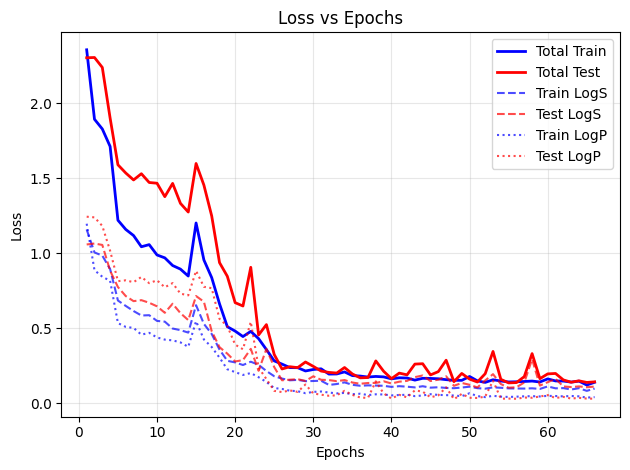

Evaluating model: 100%|██████████| 225/225 [00:00<00:00, 456.79it/s]


LogS PREDICTION METRICS:
  MSE:  0.4927
  RMSE: 0.7019
  MAE:  0.5084
  R²:   0.8941

LogP PREDICTION METRICS:
  MSE:  0.1081
  RMSE: 0.3288
  MAE:  0.2319
  R²:   0.9756


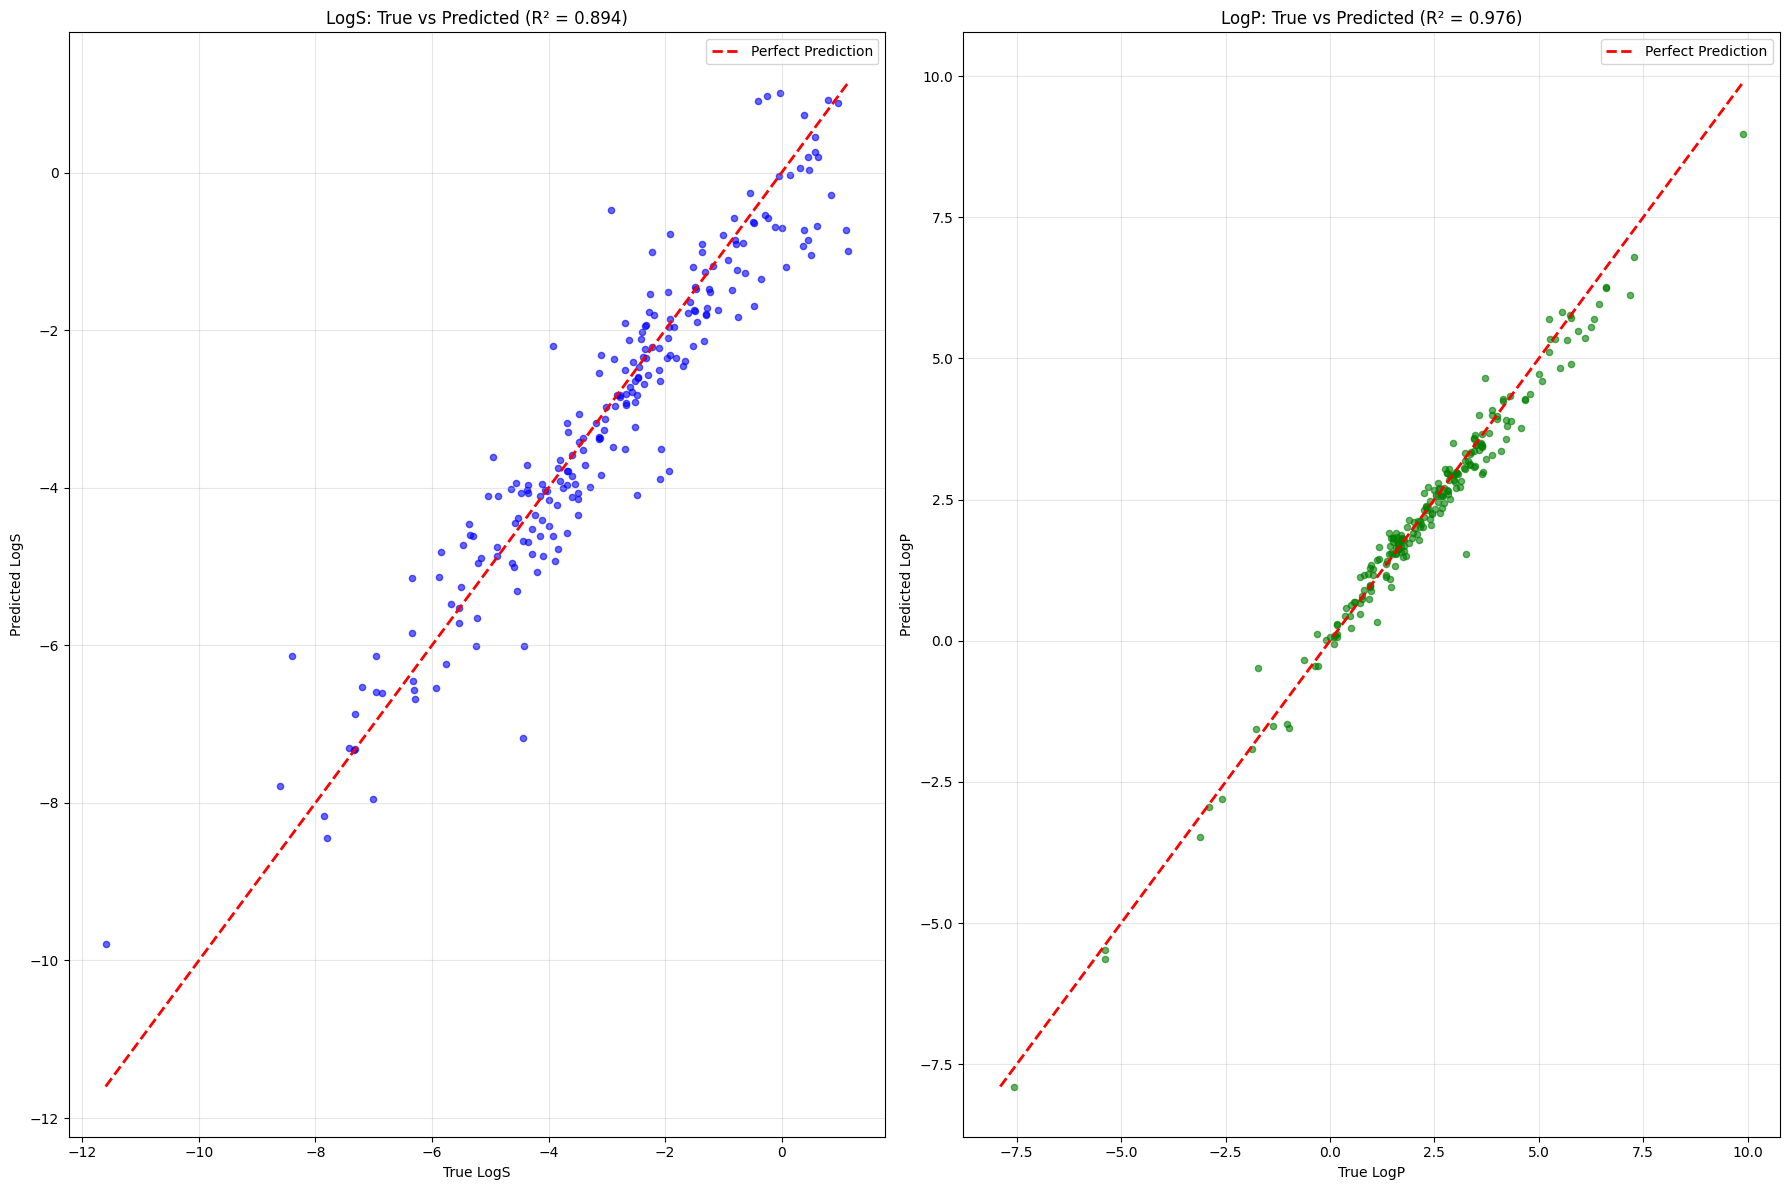

{'mae_logs': 0.5083956122398376,
 'mae_logp': 0.23194289207458496,
 'r2 logs': 0.8940907716751099,
 'r2 logp': 0.9756019115447998}

In [16]:
plot_training_results(train_losses, train_losses_logs, train_losses_logp, test_losses, test_losses_logs, test_losses_logp)
evaluate_model(
    model,
    test_loader=test_loader,
    device=device,
    scaler_logS=scaler_logS,
    scaler_logP=scaler_logP
)